# Кластеризация текстов

## Типы данных

In [1]:
#документ имя -> слово -> встречаемость слова
#документ это словарь слов, с количеством встреч в этом документе
Document = dict[str,int]
#Слово это строка
Word = str
#Слова это словарь слов с их весом
Vector = dict[str,float]
#Текст это список слов
Text = list[Word]
# матрица ассоциативности слов
Matrix = dict[Word,dict[Word,float]]


## Функции импорта докуметов из пдф файлов , субд


In [2]:
from os import listdir
from os.path import isfile, join
from PyPDF2 import PdfReader 

In [3]:
def text(file):
    file = open(file,'rb')
    reader = PdfReader(file,strict = False)
    text =""
    for page in reader.pages:
        text += page.extract_text()
    return text

def texts(directory : str) -> dict[str,str]:
    files = [f for f in listdir(directory) if isfile(join(directory, f))] 
    res = dict[str,str].fromkeys(files,"")
    #todo распаралелить , но в питоне это как-то слишком странно представлено 
    for file in files:
        try:
            res[file] = text(join(directory, file))
        except:
            print(f'exception on {file} while attemted to read it')
    return res

## Обработка текстов

In [4]:
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from numpy import linalg as LA
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import itertools
from networkx.algorithms.components import connected_components

# nltk.download()

Удаление спецсимволов , Стопслов , Токенизация и Стемминг


In [5]:
def removePunctuations(text : Text) -> Text:
    return [word for word in text if word.isalnum()]

def removeStopWords(text : Text) -> Text:
    stops = stopwords.words('english')
    return [word for word in text if word not in stops]

def tokenize(text : str) -> Text : 
    return word_tokenize(text)

def stemm (text : Text) -> Text:
    stemer = LancasterStemmer()
    return list(map(lambda w : stemer.stem(w),text))

def removeSmallValueTokens(text :Text,minLenght : int) -> Text:
    return [t for t in text if len(t) > minLenght]

Частота слов в документе / документах

In [6]:
def frequency(text: Text) -> Document:
    res = dict[str, int].fromkeys(text, 0)
    for word in text:
        res[word] += 1
    return res


def normFrequency(text: Text) -> Vector:
    prev = frequency(text)
    res = Vector.fromkeys(prev.keys(),0.0)
    for k, v in prev.items():
        res[k] = prev[k] / len(text)
    return Vector(sorted(res.items(),key = lambda item : -item[1]))

# возвращает отсортированый по невозрастанию словарь список
def docFrequency(document: Document) -> Document:
    res = dict[str, int]()
    for word in document.keys():
        if (res.__contains__(word) is False):
            res[word] = 1
        else:
            res[word] += 1
    return dict[str, int](sorted(res.items(), key=lambda item: -item[1]))


Обработчик любого текста по умолчанию

In [7]:
def defaultTextPipe(inputText : str) -> Text:
    text = inputText.lower()
    text = tokenize(text)
    text = removePunctuations(text)
    text = removeStopWords(text)
    text = stemm(text)
    text = removeSmallValueTokens(text,2)
    return text

## Обработка Документов

Образ документа 

In [8]:
def docView(
        #выбранные слова в документе -> нормальзированный вес слова
        document : Document,
        #слово -> количество документов, в котором оно встречается
        commonWords : Document,
        #количество документов
        documentCount : int
    ) -> Vector:
    
    # пока что раскроем скобки
    def a(key) :
        if(document.__contains__(key) is False): return 0.0
        return document[key]  * math.log(documentCount / commonWords[key])
    w = Vector()
    for word in commonWords: w[word] = a(word)
    norm = LA.norm(w.values(),2)
    d = Vector()
    for word in d.keys(): d[word] = w[word] / norm
    return d

Расстояние между документами

In [9]:
def dist(d1: Vector, d2: Vector) -> float:
    return max(list(map(lambda x: abs(x[0] - x[1]), zip(d1.values(), d2.values()))))

Выборка терминов из Т

In [10]:
#в данном методе не гарантируется что weightLimit не будет превышен
#ожидаемое поведение : возвращение элементов, веса которых не превышают лимит
# + элемент, который привел к привышению
def selectWords(words: Text, wightLimit: float) -> Text:
    normed = normFrequency(words)
    return selectWordsFromDictionary(normed, wightLimit)


def select_words_count(words: Text , count : float) -> Text:
    normed = normFrequency(words)
    return [x[0] for x in sorted(normed.items(),key=lambda x : x[1],reverse=True)[:count]]

def selectWordsFromDictionary(words: Vector, wightLimit: float) -> Text:
    total : float = 0.0
    #todo задача о рюкзаке
    #пока что супер ленивое решение
    def limitTotal(word : str):
        nonlocal total
        res : bool = total < wightLimit
        total += words[word]
        return res 
    
    return [w for w in words.keys() if limitTotal(w) is True ]

Матрица совместной встречаемости

In [40]:
def selectedDocumentsWords(ds: list[Text]) -> Text:
    res = Text()
    for t in ds:
        for w in t:
            if res.__contains__(w) is False:
                res.append(w)
    return res

# a _ij = среднее количество словарных окон заданного размера , в котором содержатся слова ij, из всех докуметов
def buildMatrix(documents: list[Text], selected: Text, distance: int,delimeter : int = 0) -> Matrix:
    return build_matrix_optimized(documents,selected,distance,delimeter)
    # res = Matrix.fromkeys(selected,dict[Word,float]())
    # total = 0
    # for w1 in res.keys():
    #     res[w1] = Matrix.fromkeys(selected, 0.0)
    
    # for w1 in res.keys():
    #     for w2 in res[w1].keys():
    #         if w1 != w2:
    #             total = 0
    #             for d in documents:
    #                 total += intercectedTimes(w1, w2, distance, d)
    #             res[w1][w2] = total  / len(documents)
    # return res
# проверяет содержатся ли слова в заданном промежутке в документе . возвращает количество таких интервалов


def intercectedTimes(w1: Word, w2: Word, distance: int, text: Text) -> int:
    indices = [i for i, x in enumerate(text) if x == w1]
    count = 0
    for i in indices:
        r = right(i, distance, text)
        l = left(i, distance, text)
        count +=  len([w for w in r if w == w2]) + len([w for w in l if w == w2])
    return count


def right(i: int, distance: int, text: Text) -> Text:
    f_i1 = i + 1 if ((i + 1) <= len(text)) else len(text)
    f_i2 = i + distance + 1 if i + distance + 1 <= len(text) else len(text)
    return text[f_i1:f_i2: +1]


def left(i: int, distance: int, text: Text) -> Text:
    b_i1 = i - 1 if ((i - 1) > -1) else 0
    b_i2 = i - 1 - distance if i - 1 - distance > -1 else 0
    if i == 0:
        return []
    if b_i2 >= b_i1 or (b_i2 == 0 and b_i1 > 0):
        return text[:b_i1 + 1]
    return text[b_i1:b_i2: -1]

def build_matrix_optimized(documents: list[Text], selected: Text, distance: int,delimeter : int = 0) -> Matrix:
    res = Matrix.fromkeys(selected)
    for w in selected:
        res[w] = dict[str,float].fromkeys(selected)
    for w1 in selected:
        for w2 in selected:
            res[w1][w2] = 0.0 
            
    i_start = 0
    i_end = distance
    for d in documents:
        while i_end <= len(d):
            interval = d[i_start:i_end]
            common_words = [x for x in interval if x in selected]
            
            for w1 in common_words:
                for w2 in common_words:
                        if w1 != w2 :
                            res[w1][w2] += 1
            
            i_start = i_start + 1
            i_end = i_start + distance
            
        i_start = 0
        i_end = distance
    
    ds = len(documents)
    if delimeter != 0:
        ds = delimeter
    for w1 in selected:
        for w2 in selected:
            res[w1][w2] = (res[w1][w2] / ds) 
    return res

build_matrix_optimized([["a","b","a","c","d"],["c","d","e"]],["a","b"],3)
# buildMatrix([["a","b","a","c","d"],["c","d","e"]],["a","b"],3)

{'a': {'a': 0.0, 'b': 1.5}, 'b': {'a': 1.5, 'b': 0.0}}

Выбор центров кластеров. Центр класса это слово, с наибольшим средним весом его ребер

In [12]:
def selectCentres(matrix : Matrix,count : int) -> Text:
    collapsed = Vector()
    for w1 in matrix.keys():
        collapsed[w1] = 0.0
        edgesCount = len([v for v in matrix[w1].values() if v > 0])
        if edgesCount == 0 : 
            edgesCount = 1
        for w2 in matrix[w1].keys():
        # if w1 != w2: 
            collapsed[w1] += matrix[w1][w2]
        collapsed[w1] = collapsed[w1] / edgesCount
    # dict[str, int](sorted(res.items(), key=lambda item: -item[1]))
    v : Vector = Vector(sorted(collapsed.items(), key = lambda item : - item[1]))
    return list(v.keys())[0 : count]       

## Построение графов

In [13]:
import hypernetx as hnx
from typing import Callable
from  array import array
def toNetwork(g : nx.Graph) -> Network:
    net = Network(notebook=True)
    for w in g.nodes:
        net.add_node(w,label=w,)
    for u,v in g.edges:
        net.add_edge(u,v,label=g[u][v]['weight'],value = g[u][v]['weight'])
    return net

def toGraph(matrix : Matrix) -> nx.Graph:
    res = nx.Graph()
    res.add_nodes_from(matrix.keys())
    for w1 in matrix.keys():
        for w2 in matrix[w1].keys():
            if w1 != w2 and matrix[w1][w2] != 0.0:
                res.add_edge(w1,w2,weight=matrix[w1][w2])
    return res

def show(G : nx.Graph):
    pos = nx.spring_layout(G,seed = 7)
    # pos = nx.planar_layout(G)
    # pos = nx.random_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size=math.ceil(10000/len(G.nodes())))
    nx.draw_networkx_edges(G, pos, edgelist=G.edges())
    nx.draw_networkx_labels(G, pos, font_size=2, font_family="sans-serif")
    
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G,pos,edge_labels,label_pos=0.5,verticalalignment="bottom",clip_on=False)
    
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
def check_combo(comb : tuple[str,...],diff : float,matrix : Matrix) -> bool:
    if len(comb) == 2 : return True
    
    tuples = list(itertools.combinations(comb,2))
    for t1 in tuples:
        for t2 in tuples:
            if t1 != t2:
                if abs(matrix[t1[0]][t1[1]] - matrix[t2[0]][t2[1]]) > diff:
                    return False
    # for (t1,t2) in zip(tuples[0:-1],tuples[1:]):
    
    if min(matrix[t1[0]][t1[1]] for t1 in tuples) < 1e-6:
        return False
    
    return True

def min_weight(comb: tuple[str,...],matrix : Matrix) -> float:
    if len(comb) == 2: return matrix[comb[0]][comb[1]]
    
    tuples = list(itertools.combinations(comb,2))
    
    return min([matrix[x[0]][x[1]] for x in tuples])
def max_weight(comb: tuple[str,...],matrix : Matrix) -> float:
    if len(comb) == 2: return matrix[comb[0]][comb[1]]
    
    tuples = list(itertools.combinations(comb,2))
    
    return max([matrix[x[0]][x[1]] for x in tuples])
def convertTupleToString(tup : tuple[str,...]) -> str:
        # initialize an empty string
    res : str  = ""
    for item in tup:
        res = res + item+ "_"
    return res

def convertTupleToList(tup : tuple[str,...]) -> list[str] :
    return [str(x) for x in tup]

def toHyperGraph(matrix:Matrix, diff : float,he_weight : Callable[[tuple[str,...],Matrix],float],limit: int) -> hnx.Hypergraph:
    
    verticies = matrix.keys()
    entities = dict[str,hnx.Entity]()
    
    count = limit + 1
    if count > (len(verticies) + 1):
        count = (len(verticies) + 1)
    
    for k in range(2,count):
        combs = [x for x in itertools.combinations(verticies,k) if check_combo(x,diff,matrix) is True]
        for tple in combs:
            t_str = convertTupleToString(tple)
            t_val = he_weight(tple,matrix)
            t_list = convertTupleToList(tple)
            if t_val > 0:
                entities[t_str] = (hnx.Entity(t_str,t_list,weight = t_val))
    G = hnx.Hypergraph(entities)
    return G
    
convertTupleToString(("1","2","3","4","5"))
mat = {
    "a" : {"b" : 0.5,"c" :0.3 },
    "b" : {"a" : 0.5,"c" :0.4 },
    "c" : {"a" : 0.3,"b" :0.4 }
}
hgg = toHyperGraph(mat,0.3,max_weight,5)
[hgg.edges[x] for x in hgg.edges()]

[Entity(a_b_,['b', 'a'],{'weight': 0.5}),
 Entity(a_c_,['c', 'a'],{'weight': 0.3}),
 Entity(b_c_,['c', 'b'],{'weight': 0.4}),
 Entity(a_b_c_,['c', 'b', 'a'],{'weight': 0.5})]

## Работа с графами

### Удаляем связи между центрами класторов АКА строим разрезы

In [14]:
def removeWeakestConnections(g : nx.Graph, centers : Text) -> nx.Graph :
    res : nx.Graph = g.copy()
    pairs = itertools.combinations(centers,2)
    for c1,c2 in pairs :
        while True:
            try:
                path = nx.dijkstra_path(res,c1,c2)
                edges=list(zip(path[0:],path[1:]))
                edgeValues = list(map(lambda x:res[x[0]][x[1]]['weight'] ,edges))
                edgesValues = list(zip(edges,edgeValues))
                minEdge = list(sorted(edgesValues))[0]
                res.remove_edge(minEdge[0][0],minEdge[0][1])
            except nx.NetworkXNoPath: 
                # алгоритм не нашел пути
                break
    return res

from collections import Counter
from scipy.special import comb
import hypernetx.algorithms.hypergraph_modularity as hmod

def my_hmod_precomp(H):
    # 1. compute node strenghts (weighted degrees)
    for v in H.nodes:
        H.nodes[v].strength = 0
    for e in H.edges:
        try:
            w = H.edges[e].weight
        except:
            w = 1
            # add unit weight if none to simplify other functions
            H.edges[e].weight = 1
        for v in list(H.edges[e]):
            H.nodes[v].strength += w
    # 2. compute d-weights
    ctr = Counter([len(H.edges[e]) for e in H.edges])
    for k in ctr.keys():
        ctr[k] = 0
    for e in H.edges:
        ctr[len(H.edges[e])] += H.edges[e].weight
    H.d_weights = ctr
    H.total_weight = sum(ctr.values())
    # 3. compute binomial coeffcients (modularity speed-up)
    bin_coef = {}
    for n in H.d_weights.keys():
        for k in np.arange(n // 2 + 1, n + 1):
            bin_coef[(n, k)] = comb(n, k, exact=True)
    H.bin_coef = bin_coef
    return H

def cluster_hypergraph(g : hnx.Hypergraph) -> list[(Text,hnx.Hypergraph)]:
    HG = my_hmod_precomp(g)
    K = hmod.kumar(HG)
    return ([(x,hypergraph_from_nodes(x,g)) for x in K])

def hypergraph_from_nodes(nodes : list[str], source : hnx.Hypergraph) -> hnx.Hypergraph:
    edges = [source.edges[x] for x in source.edges() if all([y in nodes for y in list(x.elements.keys())])]
    return hnx.Hypergraph(edges)


def remove_Weakest_Connections(hg : hnx.Hypergraph,centers : Text) -> hnx.Hypergraph:
    res = hg
    for c1,c2 in itertools.combinations(centers,2) :
        while True:
            path = shortest_path_vertecies(hg,c1,c2)
            if len(path) == 0:
                break
            min_edge = min([res.edges[x] for x in path],key= lambda x : x.weight)
            res = res.remove_edge(min_edge)
            
    return res

def _inner(hypergraph : hnx.Hypergraph):
    edges_as_vertecies = hypergraph.edges
    graph = nx.Graph()
    for a in edges_as_vertecies:
        graph.add_node(a) 
    for v1 in edges_as_vertecies:
        for v2 in edges_as_vertecies:
            if v1 != v2:
                e1 = set(x for x in hypergraph.edges[v1].elements) 
                e2 = set(x for x in hypergraph.edges[v2].elements)
                e = e1.intersection(e2)
                if len(e) != 0:
                    # print(e)
                    graph.add_edge(v1,v2,weight=hypergraph.edges[v1].weight)
                    graph.add_edge(v2,v1,weight=hypergraph.edges[v2].weight)
    return graph

def shortest_path_edges(hypergraph : hnx.Hypergraph, start_edge : str,end_egde :str) -> list[str]:
    if start_edge not in hypergraph.edges or end_egde not in hypergraph.edges:
        return [] 
    graph = _inner(hypergraph)
    return nx.shortest_path(graph,start_edge,end_egde)

def shortest_path_vertecies(hypergraph :hnx.Hypergraph, start_vertex : str, end_vertex :str) -> list[str]:
    if start_vertex not in hypergraph.nodes or end_vertex not in hypergraph.nodes:
        return [] 
    distances = {vertex: float('inf') for vertex in hypergraph.nodes}
    distances[start_vertex] = 0
    visited = set()
    path = []

    edges_dict = {}  # словарь для хранения ребер

    for hyperedge in hypergraph.edges():
        for v1 in hyperedge:
            for v2 in hyperedge:
                if v1 != v2:
                    edges_dict[(v1, v2)] = hyperedge  # добавляем ребро и его пару вершин в словарь

    while len(visited) < len(hypergraph):
        current_vertex = min((set(distances.keys()) - visited), key=distances.get)

        if distances[current_vertex] == float('inf'):
            break

        visited.add(current_vertex)

        for neighbor in hypergraph.neighbors(current_vertex):
            if neighbor not in visited:
                weight = edges_dict[(current_vertex, neighbor)].weight
                if distances[current_vertex] + weight < distances[neighbor]:
                    distances[neighbor] = distances[current_vertex] + weight

        if current_vertex == end_vertex:
            break

    if distances[end_vertex] == float('inf'):
        return []

    current_vertex = end_vertex

    while current_vertex != start_vertex:
        for neighbor in hypergraph.neighbors(current_vertex):
            if neighbor in visited:
                weight = edges_dict[(current_vertex, neighbor)].weight
                if distances[current_vertex] == distances[neighbor] + weight:
                    path.append(edges_dict[(current_vertex, neighbor)].uid)
                    current_vertex = neighbor
                    break
        else:
            return []

    return list(reversed(path))

### Выбираем значимые кластеры

In [15]:
def sortClustersBySize(clusters : list[nx.Graph]) -> list[nx.Graph]:
    return list(sorted(clusters,key = lambda x : -len(x.nodes())))

по числу

In [16]:
def clustersByCount(clusters: list[nx.Graph], count: int) -> list[nx.Graph]:
    return sortClustersBySize(clusters)[0:count]

по минимальному размеру кластера

In [17]:
def clustersByMinimumSize(clusters: list[nx.Graph], size: int) -> list[nx.Graph]:
    return [c for c in clusters if len(c.nodes()) >= size]

### Из языка графов переходим обратно на язык слов

In [87]:
from hypernetx import Hypergraph

def singleToText(g : nx.Graph) -> Text:
    return list(g.nodes())


def multipleToText(gs : list[nx.Graph]) -> list[Text]:
    return [singleToText(g) for g in gs]

def graph_to_matrix(g : nx.Graph,selected : Text) -> Matrix :
    res = Matrix.fromkeys(selected,dict[Word,float]())
    for w1 in res.keys():
        res[w1] = dict[Word,float].fromkeys(selected, 0.0)
        
    for w1 in res.keys():
        for w2 in res[w1].keys():
            # w1 in g.nodes and w2 in g.nodes and
            if g.has_edge(w1,w2):            
                res[w1][w2] = g[w1][w2]["weight"]
    return res

def hypergraph_to_matrix(g : Hypergraph , selected : Text) -> Matrix:
    res = Matrix.fromkeys(selected,dict[Word,float]())
    for w1 in res.keys():
        res[w1] = dict[Word,float].fromkeys(selected, 0.0)
    for x in g.edges():
        edge = g.edges[x]
        for w1 in edge:
            for w2 in edge:
                if w1 in selected and w2 in selected and w1 != w2:
                    res[w1][w2] += edge.weight
    return res

### Определяем принадлежность документа к класетру

классификация по частоте встречаемых слов. возвращается вероятность принадлежаности к кластеру

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

def classify(document : Document, clusters : dict[str,Text]) -> dict[str,float]:
    res = dict[Text,float]().fromkeys(clusters.keys(),0.0)
    freqs = dict[Text,int]().fromkeys(clusters.keys(),0)
    for c in clusters.keys() :
        freqs[c] = sum(map(lambda x : document[x] if document.keys().__contains__(x) else 0,clusters[c]))
    
    totalCount = sum(freqs.values())
    
    for c in clusters :
        if totalCount == 0 : res[c] = 0.0
        else : res[c] = freqs[c] / totalCount
    return res

def classify_hard_graph(clusters : dict[str,list[nx.Graph]],document_matrix : Matrix) -> dict[str,float]:
    mtrx = [(x, graph_to_matrix(clusters[x],document_matrix.keys())) for x in list(clusters.keys())]
    
    return dict[str,float]([(x[0], distance_matrixes(x[1],document_matrix)) for x in mtrx])
    
def distance_matrixes(m1 : Matrix, m2 : Matrix) -> float:
    # создаем две матрицы NumPy
    matrix1_array = np.array([[m1[t1][t2] for t2 in list(m1[t1].keys())] for t1 in list(m1.keys())])
    matrix2_array = np.array([[m2[t1][t2] for t2 in list(m2[t1].keys())] for t1 in list(m2.keys())])
    # вычисляем косинусное расстояние между двумя матрицами
    if len(matrix1_array) == 0 or len(matrix2_array) == 0:
        return 0.0
    return cosine_similarity(matrix1_array, matrix2_array).max()



## Проанализируем данные

In [20]:
rawDocuments2 = texts("data")

In [25]:
realNames = [d for d in rawDocuments2 if rawDocuments2[d] != '']
len(rawDocuments2) - len(names2)

2

## Кластеризация графов по отсечению слабых связей

In [22]:
#я так понимаю это очень плохой селектор и текстовый процессор, потому что он не удаляет мат формулы
selectionLimiter2 = 0.3
max_word_count = 6
matrix_interval_size = 3
max_nodes_in_edge = 3
max_edge_simmularity = 0.15
graph_clusters_count = 10
in_texts2 = list (map (lambda x : defaultTextPipe(rawDocuments2[x]),names2))
freqs2 = list (map (lambda x : frequency(x),in_texts2))
ss2 = list(map ( lambda x : select_words_count(x,max_word_count) ,in_texts2))
selected2 = selectedDocumentsWords(ss2)
m2 = buildMatrix(in_texts2,selected2,matrix_interval_size)

In [23]:
hg = toHyperGraph(m2,max_edge_simmularity,max_weight,max_nodes_in_edge)
# hg11 = toHyperGraph(m2,max_edge_simmularity,max_weight,4)
hg_clustered_build_in = cluster_hypergraph(hg)
centres = selectCentres(m2,graph_clusters_count)
g2 = toGraph(m2)
cluster = removeWeakestConnections(g2,centres)

subClusters = [cluster.subgraph(c) for c in connected_components(cluster)]
selected_clusters = clustersByCount(subClusters,graph_clusters_count)
cl_texts = dict[str,Text](zip(range(graph_clusters_count),multipleToText(selected_clusters)))
cls = dict[str,Text](zip(range(graph_clusters_count),selected_clusters))

#  Побалуемся с работой


### графы

In [144]:

texts = dict[str,Text]([(x,defaultTextPipe(rawDocuments2[x])) for x in realNames])
selected_words = dict[str,Text]([(x,select_words_count(texts[x],max_word_count)) for x in realNames])
matricies = dict[str,Matrix]([(x,buildMatrix([texts[x]],selected_words[x],matrix_interval_size,len(realNames))) for x in realNames])
metric_g_cosine = dict[str,dict[str,float]]([(x,classify_hard_graph(cls,matricies[x])) for x in realNames])
metric_g_cosine
pd.DataFrame.from_dict(metric_g_cosine,orient='index')

,0,1,2,3,4,5,6,7,8,9
102.pdf,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
103.pdf,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
10_B08-607.pdf,0.922269,0.989576,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
116.pdf,0.936947,0.991973,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
117.pdf,0.971963,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
121.pdf,0.000000,0.989442,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
127.pdf,0.986797,0.942809,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3DES Attack Merkle Hellman.pdf,0.980522,0.941858,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
62.pdf,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
64.pdf,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [145]:
metric_g_simple = dict[str,dict[str,float]]([(x,classify(frequency(defaultTextPipe(rawDocuments2[x])),cl_texts)) for x in texts])
pd.DataFrame.from_dict(metric_g_simple,orient='index')

,0,1,2,3,4,5,6,7,8,9
102.pdf,0.204056,0.183777,0.117871,0.0,0.216730,0.030418,0.106464,0.055767,0.049430,0.035488
103.pdf,0.284768,0.284768,0.205298,0.0,0.006623,0.039735,0.033113,0.079470,0.066225,0.000000
10_B08-607.pdf,0.545964,0.338565,0.052691,0.0,0.003363,0.023543,0.002242,0.004484,0.003363,0.025785
116.pdf,0.433333,0.266667,0.093651,0.0,0.095238,0.034921,0.003175,0.014286,0.036508,0.022222
117.pdf,0.288232,0.287057,0.091489,0.0,0.120866,0.067652,0.039282,0.019473,0.033406,0.052543
121.pdf,0.246377,0.475362,0.028986,0.0,0.130435,0.043478,0.008696,0.000000,0.000000,0.066667
127.pdf,0.483647,0.399405,0.092170,0.0,0.000991,0.006938,0.003964,0.000000,0.002973,0.009911
3DES Attack Merkle Hellman.pdf,0.394850,0.463519,0.051502,0.0,0.008584,0.042918,0.004292,0.000000,0.004292,0.030043
62.pdf,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64.pdf,0.490909,0.436364,0.018182,0.0,0.000000,0.054545,0.000000,0.000000,0.000000,0.000000


36
39


C:\Users\cross\AppData\Local\Temp\ipykernel_18036\3815905157.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z, c="red", cmap='viridis')
C:\Users\cross\AppData\Local\Temp\ipykernel_18036\3815905157.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z2, c="green", cmap='viridis')


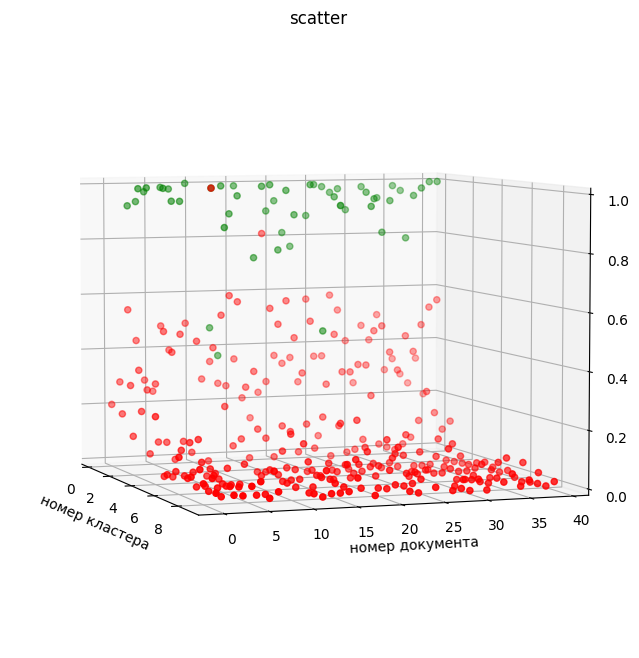

In [146]:
import matplotlib.pyplot as plt

x = range(10)
y = range(len(realNames))
def f(x,y,d):
    x_key = list(d.keys())[y]
    y_key = list(d[x_key].keys())[x]
    return d[x_key][y_key] if d[x_key][y_key] > 0 else -1
    # return docs[names_g[y]][cls_g[x]]
    
def f2(x,y,d):
    x_key = list(d.keys())[y]
    y_key = list(d[x_key].keys())[x]
    return d[x_key][y_key]
    # return docs[names_g[y]][cls_g[x]]
X, Y = np.meshgrid(x, y)
Z_values = np.matrix([[f2(xx,yy,metric_g_cosine) for xx in x] for yy in y])
Z_2_values = np.matrix([[f2(xx,yy,metric_g_simple) for xx in x] for yy in y])
Z = np.matrix([[f(xx,yy,metric_g_simple) for xx in x] for yy in y])
Z2 = np.matrix([[f(xx,yy,metric_g_cosine) for xx in x] for yy in y])
# Z2 = np.matrix([[f(xx,yy,docs2) for xx in x] for yy in y])
z1_good = len([x for x in Z_values if x.max() > 0])
z2_good = len([x for x in Z_2_values if x.max() > 0])
print(z1_good)
print(z2_good)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=5, azim=-20)
ax.scatter(X, Y, Z, c="red", cmap='viridis')
ax.scatter(X, Y, Z2, c="green", cmap='viridis')
ax.set_title('scatter')
ax.set_xlabel('номер кластера')
ax.set_ylabel('номер документа')
ax.set_zlabel('схожесть')
ax.set_zlim(0, 1)

plt.show()


### гиперграфы

In [104]:
def classify_hypergraphs(
    clusters : dict[str,hnx.Hypergraph],
    document : hnx.Hypergraph,
    distance : Callable[[ hnx.Hypergraph, hnx.Hypergraph],float]) -> dict[str,float]:
    
    return dict[str,float]([(x,distance(clusters[x],document)) for x in clusters])

def hypergraph_distance_simple(cluster : hnx.Hypergraph, doc : hnx.Hypergraph) -> float:
    nodes_cluster = list(cluster.nodes)
    nodes_doc = list(doc.nodes)
    freqs = [x for x in nodes_doc if x in nodes_cluster]
    total = len(freqs)
    if len(nodes_doc) == 0:
        return 0.0
    return total/len(nodes_doc)

    
def hypergraph_distance_nodes(cluster : hnx.Hypergraph, doc : hnx.Hypergraph) -> float:
    cluster_matrix = hypergraph_to_matrix(cluster,list(doc.nodes))
    doc_matrix = hypergraph_to_matrix(doc,list(doc.nodes))
    return distance_matrixes(cluster_matrix,doc_matrix)  

def hypergraph_distance_edges(cluster : hnx.Hypergraph, doc : hnx.Hypergraph) -> float:
    c = cluster.dual()
    d = doc.dual()
    return hypergraph_distance_nodes(c,d)  

# hypergraph_distance_edges(hg_clustered_build_in[0][1],h_matricies["116.pdf"])
clsdict_hg = dict([(str(x[0]),x[1][1]) for x in zip(range(5),hg_clustered_build_in)])
len(clsdict_hg)
# classify_hypergraphs(clsdict_hg,h_matricies["116.pdf"],hypergraph_distance_simple)


5

In [109]:
doc_hg = dict[str,hnx.Hypergraph]([(x,toHyperGraph(buildMatrix([texts[x]],selected_words[x],matrix_interval_size,len(realNames)),max_edge_simmularity,max_weight,max_nodes_in_edge)) for x in realNames])
metric_hg_simple = dict[str,dict[str,float]]([(x,classify_hypergraphs(clsdict_hg,doc_hg[x],hypergraph_distance_simple)) for x in realNames])
metric_hg_nodes = dict[str,dict[str,float]]([(x,classify_hypergraphs(clsdict_hg,doc_hg[x],hypergraph_distance_nodes)) for x in realNames])
metric_hg_edges = dict[str,dict[str,float]]([(x,classify_hypergraphs(clsdict_hg,doc_hg[x],hypergraph_distance_edges)) for x in realNames])


39
39
22


C:\Users\cross\AppData\Local\Temp\ipykernel_18036\3510505628.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z, c="green", cmap='viridis')
C:\Users\cross\AppData\Local\Temp\ipykernel_18036\3510505628.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z2, c="orange", cmap='viridis')
C:\Users\cross\AppData\Local\Temp\ipykernel_18036\3510505628.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X, Y, Z3, c="black", cmap='viridis')


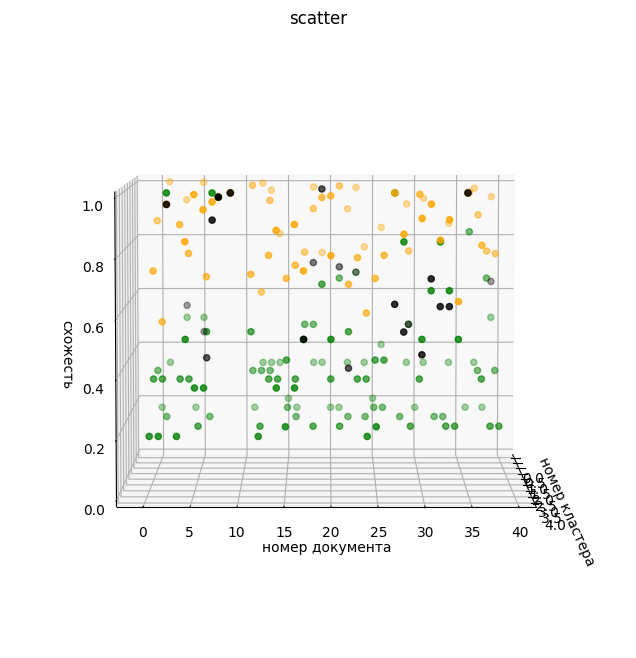

In [143]:


x = range(len(clsdict_hg))
y = range(len(realNames))
X, Y = np.meshgrid(x, y)
Z = np.matrix([[f(xx,yy,metric_hg_simple) for xx in x] for yy in y])
Z2 = np.matrix([[f(xx,yy,metric_hg_nodes) for xx in x] for yy in y])
Z3 = np.matrix([[f(xx,yy,metric_hg_edges) for xx in x] for yy in y])
z1_good = len([x for x in Z if x.max() > 0])
z2_good = len([x for x in Z2 if x.max() > 0])
z3_good = len([x for x in Z3 if x.max() > 0])
print(z1_good)
print(z2_good)
print(z3_good)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=5, azim=0)
ax.scatter(X, Y, Z, c="green", cmap='viridis')
ax.scatter(X, Y, Z2, c="orange", cmap='viridis')
ax.scatter(X, Y, Z3, c="black", cmap='viridis')
ax.set_title('scatter')
ax.set_xlabel('номер кластера')
ax.set_ylabel('номер документа')
ax.set_zlabel('схожесть')
ax.set_zlim(0, 1)
plt.show()

# Создадим кластеры по первым двум папкам, и посмотрим куда он отнесет докумнеты из третьей

In [ ]:
selectedData = texts("forClust")
testData = texts("forTests")

exception on 76.pdf while attamted to read it


In [ ]:
selectionLimiter = 0.03
wordMaxLengthConnection = 5
centresCount = 4

minWordCountForCluster = 2


# уберем из списка непрочтенные файлы
names = [n for n in selectedData if selectedData[n] != '']

in_texts = list (map (lambda x : defaultTextPipe(selectedData[x]),names))
freqs = list (map (lambda x : frequency(x),in_texts))

ss2 = list(map ( lambda x : selectWords(x,selectionLimiter) ,in_texts))
selected_words = selectedDocumentsWords(ss2)


matrix = buildMatrix(in_texts,selected_words,wordMaxLengthConnection)
centres = selectCentres(m2,centresCount)

print(centres)

graph = toGraph(matrix)

g_net = toNetwork(graph)
# g_net.toggle_physics(True)
g_net.toggle_stabilization(True)
g_net.show("init_graph.html")


clustered_graph = removeWeakestConnections(graph,centres)

cg_Net = toNetwork(clustered_graph)
# cg_Net.toggle_physics(True)
cg_Net.toggle_stabilization(True)

cg_Net.show("clustered_graph.html")

clusters = [clustered_graph.subgraph(c).copy() for c in connected_components(cluster)]

selected_clusters = clustersByMinimumSize(clusters,minWordCountForCluster)
cl_texts = dict[str,Text](zip(range(0,len(selected_clusters) + 1),multipleToText(selected_clusters)))

print(cl_texts)

realNames = [n for n in testData if testData[n] != '']
metric_g_cosine = dict[str,dict[str,float]]([(x,classify(frequency(defaultTextPipe(testData[x])),cl_texts)) for x in realNames])
document_relation_ratio =pd.DataFrame.from_dict(metric_g_cosine,orient='index')

['2328', 'graph', 'interv', 'key']
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
{0: ['graph', '2328', 'key', 'bit', 'diﬀ', 'interv'], 1: ['precondit', 'attack', 'root', 'meas']}


,0,1
102.pdf,1.000000,0.000000
103.pdf,0.000000,1.000000
10_B08-607.pdf,0.641176,0.358824
116.pdf,1.000000,0.000000
117.pdf,0.879157,0.120843
121.pdf,0.933333,0.066667
127.pdf,0.721992,0.278008
3DES Attack Merkle Hellman.pdf,0.680000,0.320000
62.pdf,0.000000,0.000000
64.pdf,0.333333,0.666667
